In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# The following code is copied verbatim from @pjsier Rolling Rain N-Year Threshold.pynb
# Loading in hourly rain data from CSV, parsing the timestamp, and adding it as an index so it's more useful

rain_df = pd.read_csv('data/ohare_hourly_observations.csv')
rain_df['datetime'] = pd.to_datetime(rain_df['datetime'])
rain_df = rain_df.set_index(pd.DatetimeIndex(rain_df['datetime']))
print(rain_df.dtypes)
rain_df.head()

Unnamed: 0                          int64
datetime                   datetime64[ns]
dewpoint_fahrenheit               float64
drybulb_fahrenheit                float64
hourly_precip                     float64
id                                  int64
latitude                          float64
longitude                         float64
old_station_type                   object
relative_humidity                 float64
report_type                        object
sealevel_pressure                 float64
sky_condition                      object
sky_condition_top                  object
station_pressure                  float64
station_type                      float64
visibility                        float64
wban_code                           int64
weather_types                      object
wetbulb_fahrenheit                float64
wind_direction                     object
wind_direction_cardinal            object
wind_speed                        float64
call_sign                         

d:\data_science_projects\chicagorain\virtualenvs\nyear-venv\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,datetime,dewpoint_fahrenheit,drybulb_fahrenheit,hourly_precip,id,latitude,longitude,old_station_type,relative_humidity,...,station_pressure,station_type,visibility,wban_code,weather_types,wetbulb_fahrenheit,wind_direction,wind_direction_cardinal,wind_speed,call_sign
2016-08-16 22:51:00,0,2016-08-16 22:51:00,65.0,74.0,0.0,398063571,NaN,NaN,NaN,74.0,...,29.37,11.0,10.0,94846,NaN,68.0,200,SSW,7.0,KORD
2016-08-16 21:51:00,1,2016-08-16 21:51:00,64.0,74.0,0.0,397933331,NaN,NaN,NaN,71.0,...,29.36,11.0,10.0,94846,NaN,68.0,200,SSW,5.0,KORD
2016-08-16 20:51:00,2,2016-08-16 20:51:00,64.0,76.0,0.0,397986035,NaN,NaN,NaN,67.0,...,29.35,11.0,10.0,94846,NaN,68.0,220,SW,3.0,KORD
2016-08-16 19:51:00,3,2016-08-16 19:51:00,64.0,78.0,0.0,398003060,NaN,NaN,NaN,62.0,...,29.34,11.0,10.0,94846,NaN,69.0,NaN,NaN,0.0,KORD
2016-08-16 18:51:00,4,2016-08-16 18:51:00,65.0,76.0,0.0,397972638,NaN,NaN,NaN,69.0,...,29.32,11.0,10.0,94846,NaN,69.0,160,SSE,6.0,KORD


In [3]:
chi_rain_series = rain_df['hourly_precip'].resample('1H').max()

In [4]:
# This is where I break with @pjsier

In [5]:
# I am assuming here that a single hour cannot be part of more than one storm in the event_endtimes list.
# Therefore, I am looping through the list and throwing out any storms that include hours from heavier storms in the
# same block of time.=
def get_storms_without_overlap(event_endtimes, hours):
    times_taken = []
    ret_val = []
    for i in range(len(event_endtimes)):
        timestamp = event_endtimes.iloc[i].name
        times_here = []
        for h in range(hours):
            times_here.append(timestamp - pd.DateOffset(hours=h))
        if not bool(set(times_here) & set(times_taken)):
            times_taken.extend(times_here)
            ret_val.append({'start': timestamp - pd.DateOffset(hours=hours), 'end': timestamp, 'inches': event_endtimes.iloc[i]['hourly_precip']})
    return ret_val

In [6]:
# Find the 100 year event.  First, define the storm as based in Illinois Bulletin 70 as the number of inches
# of precipition that falls over a given span of straight hours.
_100_year_storm_milestones = [{'hours': 240, 'inches': 11.14}, {'hours':120, 'inches': 9.96},
                              {'hours': 72, 'inches': 8.78}, {'hours': 48, 'inches': 8.16}, {'hours': 24, 'inches': 7.58},
                             {'hours': 18, 'inches': 6.97}, {'hours': 12, 'inches': 6.59}, {'hours': 6, 'inches': 5.68},
                             {'hours': 3, 'inches': 4.9}, {'hours': 2, 'inches': 4.47}, {'hours': 1, 'inches': 3.51}]
all_storms = []
print("\tSTART\t\t\tEND\t\t\tINCHES")
for storm_hours in _100_year_storm_milestones:
    rolling = pd.DataFrame(chi_rain_series.rolling(window=storm_hours['hours']).sum())
    event_endtimes = rolling[(rolling['hourly_precip'] >= storm_hours['inches'])]
    event_endtimes = event_endtimes.sort_values(by='hourly_precip', ascending=False)
    storms = get_storms_without_overlap(event_endtimes, storm_hours['hours'])

    if len(storms) > 0:
        print("Across %s hours" % storm_hours['hours'])
        for storm in storms:
            print('\t%s\t%s\t%s inches' % (storm['start'], storm['end'], storm['inches']))
        all_storms.extend(storms)

	START			END			INCHES
Across 240 hours
	2015-01-25 02:00:00	2015-02-04 02:00:00	13.765 inches
	2008-09-04 12:00:00	2008-09-14 12:00:00	12.06 inches
Across 120 hours
	2015-01-30 18:00:00	2015-02-04 18:00:00	13.515 inches
Across 72 hours
	2015-01-31 18:00:00	2015-02-03 18:00:00	13.48 inches
Across 48 hours
	2015-01-31 11:00:00	2015-02-02 11:00:00	13.385 inches
	2011-07-21 12:00:00	2011-07-23 12:00:00	8.45 inches
	2008-09-12 14:00:00	2008-09-14 14:00:00	8.365 inches
Across 24 hours
	2015-02-01 10:00:00	2015-02-02 10:00:00	12.78 inches
	2011-07-22 07:00:00	2011-07-23 07:00:00	8.22 inches
Across 18 hours
	2015-02-01 16:00:00	2015-02-02 10:00:00	12.375 inches
	2011-07-22 08:00:00	2011-07-23 02:00:00	7.29 inches
Across 12 hours
	2015-02-01 22:00:00	2015-02-02 10:00:00	10.42 inches
	2011-07-22 22:00:00	2011-07-23 10:00:00	6.935 inches
Across 6 hours
	2015-02-02 04:00:00	2015-02-02 10:00:00	9.655 inches
	2011-07-22 22:00:00	2011-07-23 04:00:00	6.915 inches
Across 3 hours
	2015-02-02 07:00:00	20

In [7]:
# Analysis Questions
# 1/25/2015 - 2/4/2015 - Worst storm by far in quantity, but Jan-Feb -- is it snow?
# 9/4/2008 - 9/14/2008 - This only appeared on the 10-day event, so it must've been well distributed across the days?
# 7/21/2011 - 7/23/2011 - Very heavy summer storm!

In [8]:
# Examining the storm from 7/21-2011 - 7/23/2011
import datetime
july_2011_storm = chi_rain_series.loc[(chi_rain_series.index >= datetime.datetime(2011,7,20)) & (chi_rain_series.index <= datetime.datetime(2011,7,24))]
july_2011_storm.head()

2011-07-20 00:00:00    0.00
2011-07-20 01:00:00    0.00
2011-07-20 02:00:00    0.02
2011-07-20 03:00:00    0.00
2011-07-20 04:00:00    0.00
Freq: H, Name: hourly_precip, dtype: float64

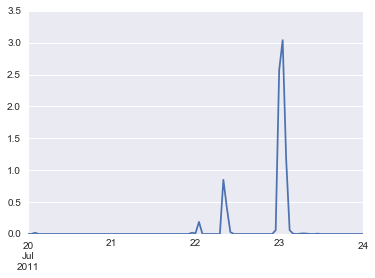

In [9]:
july_2011_storm.plot()

In [10]:
# Let's take a look at the cumulative buildup of the storm over time
cumulative_rainj11 = pd.DataFrame(july_2011_storm).hourly_precip.cumsum()
cumulative_rainj11.head()

2011-07-20 00:00:00    0.00
2011-07-20 01:00:00    0.00
2011-07-20 02:00:00    0.02
2011-07-20 03:00:00    0.02
2011-07-20 04:00:00    0.02
Freq: H, Name: hourly_precip, dtype: float64

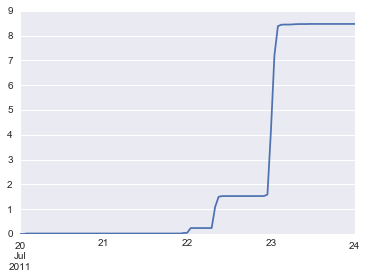

In [11]:
cumulative_rainj11.plot()

In [12]:
cumulative_rainj11.loc[(cumulative_rainj11.index >= datetime.datetime(2011,7,22,21,0,0)) & (cumulative_rainj11.index <= datetime.datetime(2011,7,23,5,0,0))]

2011-07-22 21:00:00    1.530
2011-07-22 22:00:00    1.530
2011-07-22 23:00:00    1.590
2011-07-23 00:00:00    4.160
2011-07-23 01:00:00    7.200
2011-07-23 02:00:00    8.380
2011-07-23 03:00:00    8.440
2011-07-23 04:00:00    8.445
2011-07-23 05:00:00    8.445
Freq: H, Name: hourly_precip, dtype: float64

In [13]:
# We got a crazy, crazy downpour from about 11:00PM until 2:00AM.  That alone was a 100-year storm, where we got 6.79 inches
# in 3 hours.  That would've been a 100-year storm if we'd have gotten that in 12 hours!